In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.offsetbox
import rmgpy.chemkin
import matplotlib.lines as mlines

import os
import sys
import seaborn as sns
import matplotlib.colors as mcolors

sys.path.append(os.path.join(os.environ['DFT_DIR'], '..', 'database'))
import database_fun

%matplotlib inline

In [2]:
# load Aramco, RMG, and uncertainties


mech_1_inp = '/home/moon/autoscience/aramco/flux_diagram/chem_annotated.inp'
mech_1_dict = '/home/moon/autoscience/aramco/species_dictionary.txt'
mech_1_label = 'Aramco 3.0'
species_listA, reaction_listA = rmgpy.chemkin.load_chemkin_file(mech_1_inp, mech_1_dict)

mech_2_inp = '/home/moon/autoscience/fuels/butane_20240126/chem_annotated.inp'
mech_2_dict = '/home/moon/autoscience/fuels/butane_20240126/species_dictionary.txt'
mech_2_label = 'RMG-min-1'
species_list1, reaction_list1 = rmgpy.chemkin.load_chemkin_file(mech_2_inp, mech_2_dict)
uncertainty1 = np.load(os.path.join(os.path.dirname(mech_2_inp), 'gao_reaction_uncertainty.npy'))
assert len(uncertainty1) == len(reaction_list1)

mech_3_inp = '/home/moon/autoscience/fuels/butane_20240501/chem_annotated.inp'
mech_3_dict = '/home/moon/autoscience/fuels/butane_20240501/species_dictionary.txt'
mech_3_label = 'RMG-min-7'
species_list7, reaction_list7 = rmgpy.chemkin.load_chemkin_file(mech_3_inp, mech_3_dict)

uncertainty7 = np.load(os.path.join(os.path.dirname(mech_3_inp), 'gao_reaction_uncertainty.npy'))
assert len(uncertainty7) == len(reaction_list7)

In [3]:
def get_reaction_indices(reaction_list, ref_rxn):
    reaction_indices = []
    for i in range(len(reaction_list)):
        if reaction_list[i].is_isomorphic(ref_rxn):
            reaction_indices.append(i)
    return reaction_indices

In [4]:
def reactions_in_same_direction(reactionA, reactionB):
    reactantsA = [x.smiles for x in reactionA.reactants]
    reactantsB = [x.smiles for x in reactionB.reactants]
        
    return reactantsA[0] in reactantsB

In [ ]:
# List of kinetics that were recalculated each round - these are database indices
plot_list = [
    288, 4724, 5046, 4778, 4736, 4729, 4728, 50, 4752, 5047,
    4779, 286, 246, 5596, 808, 915, 4732, 518, 4737, 5446,
    324, 4738, 7841, 804, 809, 4721, 245, 945, 213, 289,
    422, 805, 4796, 1077, 1111, 1706, 4917, 417, 319, # species 21 was part of this set
    313, 278, 314, 52, 5056, 405, 5102, 521, 404, 410,
    4733, 296, 321, 301, 280, 253, 459, 1736, 1778, 299
]

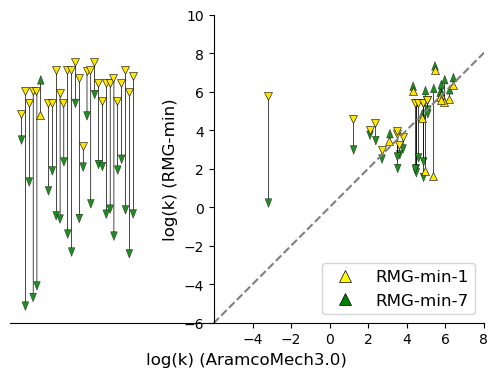

In [61]:
# Define reaction condition at which kinetics are plotted for this figure
T = 830
P = 1013250

aramco_logks = np.zeros(len(plot_list))
rmg1_logks = np.zeros(len(plot_list))
rmg7_logks = np.zeros(len(plot_list))

space_count = 0  # index to help space out the reaction kinetics on the left of the plot (the ones not found in Aramco)
for m, db_index in enumerate(plot_list):
    ref_rxn = database_fun.index2reaction(db_index)
    my_kinetics = []
    my_labels = ['RMG-1', 'RMG-7', 'Aramco 3.0']
    
    # Find the exact reaction in RMG-min-1 that matches the database index
    matches1 = get_reaction_indices(reaction_list1, ref_rxn)
    if matches1:
        my_kinetics.append([reaction_list1[x] for x in matches1])
        for rxn in [reaction_list1[x] for x in matches1]:
            assert reactions_in_same_direction(rxn, reaction_list1[matches1[0]])
    else:
        my_kinetics.append(None)
    
    # Find the exact reaction in RMG-min-7 that matches the database index
    matches7 = get_reaction_indices(reaction_list7, ref_rxn)
    if matches7:
        my_kinetics.append([reaction_list7[x] for x in matches7])
        for rxn in [reaction_list7[x] for x in matches7]:
            assert reactions_in_same_direction(rxn, reaction_list7[matches7[0]])
    else:
        my_kinetics.append(None)
    
    # Find the exact reaction in AramcoMech3.0 that matches the database index
    matchesA = get_reaction_indices(reaction_listA, ref_rxn)
    if matchesA:
        if len(matchesA) > 1:
            print('Aramco has duplicates!')
            raise ValueError
        
        # check for reverse
        if not reactions_in_same_direction(reaction_listA[matchesA[0]], reaction_list7[matches7[0]]):
            new_rxn = rmgpy.reaction.Reaction()
            new_rxn.reactants = reaction_listA[matchesA[0]].products
            new_rxn.products = reaction_listA[matchesA[0]].reactants
            new_rxn.kinetics = reaction_listA[matchesA[0]].generate_reverse_rate_coefficient()
            my_kinetics.append([new_rxn])
        else:
            my_kinetics.append([reaction_listA[matchesA[0]]])
    else:
        my_kinetics.append(None)
    
    
    # Get the kinetics for the given mechanism and reactor condition
    k1 = np.nan
    if my_kinetics[0]:
        k1 = np.sum([rxn.get_rate_coefficient(T, P) for rxn in my_kinetics[0]])
    rmg1_logks[m] = np.log10(k1)
    
    k7 = np.nan
    if my_kinetics[1]:
        k7 = np.sum([rxn.get_rate_coefficient(T, P) for rxn in my_kinetics[1]])
    rmg7_logks[m] = np.log10(k7)
    
    
    # This is set as a highly negative value to push reaction kinetics not found in Aramco
    # to the far left of the plot
    kA = 10 ** -16.0  
    if my_kinetics[2]:
        kA = np.sum([rxn.get_rate_coefficient(T, P) for rxn in my_kinetics[2]])
        aramco_logks[m] = np.log10(kA)
    else:
        aramco_logks[m] = np.log10(kA) + 0.2 * space_count
        space_count += 1.0
        
plt.figure(figsize=(10, 4))

start_color = mcolors.hex2color(mcolors.CSS4_COLORS['yellow'])  # make it yellow, but fade it 70% with alpha
rmg1_color = (1.0, 0.9, 0.0)
rmg7_color = mcolors.hex2color(mcolors.CSS4_COLORS['forestgreen'])
aramco_color = (0.18627451, 0.48823529, 0.94117647)

pointsize = 10

ARROW_OFFSET = -0.025
for i in range(len(rmg7_logks)):
    if rmg7_logks[i] < rmg1_logks[i]:
        label = '_no_legend'
        plt.plot(aramco_logks[i, ] + ARROW_OFFSET, rmg1_logks[i, ], marker='v', markersize=6, color=rmg1_color,
                 markeredgewidth=0.4, markeredgecolor='black', label=label)
    else:
        label = '_no_legend'
        plt.plot(aramco_logks[i] + ARROW_OFFSET, rmg1_logks[i], marker='^', markersize=6, color=rmg1_color,
                 markeredgewidth=0.4, markeredgecolor='black', label=label)
        
    label7 = '_no_legend'
    plt.arrow(aramco_logks[i], rmg1_logks[i], 0, rmg7_logks[i] - rmg1_logks[i], head_width=0.35, linewidth = 0.25,
              facecolor=rmg7_color, label=label7, head_length=0.45)


ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
minlim = min(ax.get_xlim()[0], ax.get_ylim()[0])
maxlim = max(ax.get_xlim()[1], ax.get_ylim()[1])
plt.plot(np.linspace(minlim, maxlim, 101), np.linspace(minlim, maxlim, 101), color='grey', linestyle='dashed')

plt.xlim(-16.6, 6.5)
plt.ylim(-6, 10)


plt.xlabel('log(k) (AramcoMech3.0)', fontsize=12)
plt.ylabel('log(k) (RMG-min)', fontsize=12)



ax.set_xticks(ax.get_yticks()[1:-1])
ax.spines['left'].set_position(('data', -6))


# Custom legend
yellow_circle = mlines.Line2D([], [], color='yellow', marker='^', linestyle='None',
                          markersize=8, label='RMG-min-1', markeredgewidth=0.5, markeredgecolor='black')
green_triangle = mlines.Line2D([], [], color='green', marker='^', linestyle='None',
                          markersize=8, label='RMG-min-7', markeredgewidth=0.5, markeredgecolor='black')

plt.legend(handles=[yellow_circle, green_triangle], loc='lower right', fontsize=12)

plt.savefig('kinetics_parity.svg', bbox_inches='tight')
# -Inf and axis break notations added manually...
